In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("s")
stop_words.add("th")
stop_words.add("nd")
stop_words.add("rd")
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')#changing words to the core word they were derived from having same meaning as otherwise they will be given different tokens resulting 
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
from sklearn.metrics import classification_report
import tensorflow as tf
import scipy
from collections import Counter
!pip install emoji
import emoji

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df=pd.read_csv('Train_suicide1.csv')

In [ ]:
df

,Tweet,Suicide
0,i hate myself so much i want to KILL myself ho...,Potential Suicide post
1,RT @DrugForumsBest: I woke up with a bag over ...,Potential Suicide post
2,i wanna fucking kill myself,Potential Suicide post
3,why do i destroy all my opportunities? am i go...,Potential Suicide post
4,u - understand what the fuck im doing wrong wi...,Potential Suicide post
...,...,...
1594,hi! just joined and i think it's brill! haha s...,Not Suicide post
1595,@WilliamSledd Love the videos William New to t...,Not Suicide post
1596,@itsanimesh I got an Openmoko FreeRunner and n...,Not Suicide post
1597,@PeoplemapsJulie I am looking for the berocca ...,Not Suicide post


In [ ]:
df=df.dropna()

In [ ]:
df.isna().sum()

Tweet      0
Suicide    0
dtype: int64

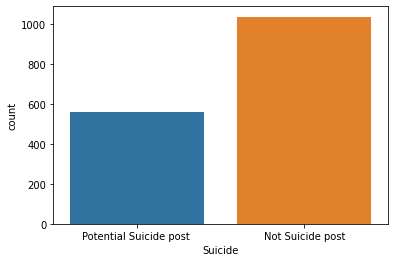

In [ ]:
sns.countplot(x="Suicide", data=df)

In [ ]:
#as we can see the dataset is imbalanced, to resolve this we are going to make the number of entries for each label euqal to one aother

In [ ]:
df["Suicide"].unique()

array(['Potential Suicide post ', 'Not Suicide post'], dtype=object)

In [ ]:
suicidal=df[df["Suicide"]=="Potential Suicide post "]
not_suicidal=df[df["Suicide"]=="Not Suicide post"]

In [ ]:
print("number of suicidal tweets = "+str(len(suicidal)))

number of suicidal tweets = 559


In [ ]:
print("number of non suicidal tweets = "+str(len(not_suicidal)))

number of non suicidal tweets = 1038


In [ ]:
not_suicidal=not_suicidal.sample(frac=1).reset_index(drop=True)
not_suicidal=not_suicidal[:559]

In [ ]:
dataset=suicidal.append(not_suicidal,ignore_index=True)

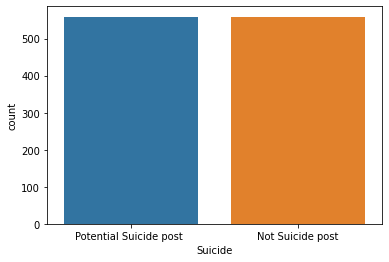

In [ ]:
sns.countplot(x="Suicide", data=dataset)

In [ ]:
dataset=dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
dataset

,Tweet,Suicide
0,me when i finally die after saying i want to d...,Potential Suicide post
1,@_WolfGirl_ May 6th We couldn't wait any longe...,Not Suicide post
2,everything that you’ve ever dreamed of,Potential Suicide post
3,"Congratulations, John! I'm a creepy actor, not...",Not Suicide post
4,@Lady_Twitster Ah it's not the same since the ...,Not Suicide post
...,...,...
1113,@coollike don't quit Twitter,Not Suicide post
1114,RT @cparham65: Liberals say conservatives are ...,Potential Suicide post
1115,RT @elonmusk: Congratulations @SpaceX team! Th...,Not Suicide post
1116,RT @lisapryor23: @MillwallFC @zampathelion wha...,Not Suicide post


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118 entries, 0 to 1117
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1118 non-null   object
 1   Suicide  1118 non-null   object
dtypes: object(2)
memory usage: 17.6+ KB


In [ ]:
#preprocessing the dataset

In [ ]:
def pre(text):
 text=re.sub("RT", "", text)#remove RT
 text=re.sub("#([a-zA-Z0-9_]+)",' ',text)#remove hash tag
 text=re.sub("@[A-Za-z0-9_]+"," ", text)#remove mention
 text=emoji.demojize(text, delimiters=(" ", " "))#replace emoji with text
 text=re.sub("_",' ',text)
 text=text.lower()#lowercase
 text=re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", text)#remove website
 text=re.sub(":", " ", text)
 text=re.sub(r'[\w\.-]+@[\w\.-]+','',text)#remove email
 text=re.sub(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]*','', text) #remove special charactors 
 text=re.sub(r'[^a-zA-Z\s]', ' ', text)#keep only text
 text=text.split()#tokenizing text
 text=str([word for word in (text) if not word in stop_words])#remove stopwords
 text=" ".join([lemmatizer.lemmatize(word) for word in text.split()])#lemmatize
 return text

In [ ]:
processed=[]
for i in dataset['Tweet']:
  processed.append(pre(i))

In [ ]:
dataset["pre"]=processed

In [ ]:
dataset

,Tweet,Suicide,pre
0,me when i finally die after saying i want to d...,Potential Suicide post,"['finally', 'die', 'saying', 'want', 'die', 'e..."
1,@_WolfGirl_ May 6th We couldn't wait any longe...,Not Suicide post,"['may', 'couldnt', 'wait', 'longeri', 'waiting..."
2,everything that you’ve ever dreamed of,Potential Suicide post,"['everything', 'ever', 'dreamed']"
3,"Congratulations, John! I'm a creepy actor, not...",Not Suicide post,"['congratulations', 'john', 'im', 'creepy', 'a..."
4,@Lady_Twitster Ah it's not the same since the ...,Not Suicide post,"['ah', 'since', 'old', 'days', 'orangeface', '..."
...,...,...,...
1113,@coollike don't quit Twitter,Not Suicide post,"['dont', 'quit', 'twitter']"
1114,RT @cparham65: Liberals say conservatives are ...,Potential Suicide post,"['liberals', 'say', 'conservatives', 'evil', '..."
1115,RT @elonmusk: Congratulations @SpaceX team! Th...,Not Suicide post,"['congratulations', 'team', 'thanks', 'much', ..."
1116,RT @lisapryor23: @MillwallFC @zampathelion wha...,Not Suicide post,"['fun', 'day']"


In [ ]:
#Visulization

In [ ]:
data=dataset[dataset.Suicide == 'Not Suicide post']['pre']
bag = []
string=str()
for j in list(data):
  for i in j:
   if i>='a' and i<='z':
     string=str(string)+i
   elif len(string)>0:
     bag.append(string)
     string=str()

com = Counter(((bag)))
com = com.most_common(1000)
com = list(dict(com).keys())

In [ ]:
print("Top 10 non suidical words \n"+str(com[:10]))

Top 10 non suidical words 
['good', 'im', 'today', 'like', 'day', 'love', 'going', 'get', 'one', 'twitter']


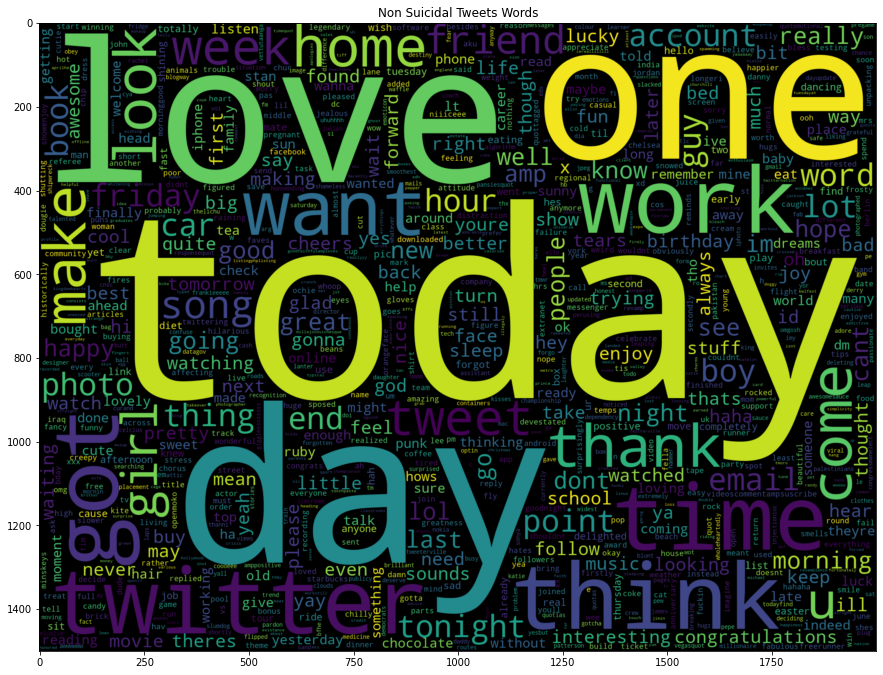

In [ ]:
plt.figure(figsize = (15,20)) 
plt.title("Non Suicidal Tweets Words")
wc = WordCloud(max_words = 1000, width = 2000 , height = 1500).generate(" ".join((com)))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
data=dataset[dataset.Suicide == 'Potential Suicide post ']['pre']
bag = []
string=str()
for j in list(data):
  for i in j:
   if i>='a' and i<='z':
     string=str(string)+i
   elif len(string)>0:
     bag.append(string)
     string=str()

com = Counter(((bag)))
com = com.most_common(1000)
com = list(dict(com).keys())

In [ ]:
print("Top 10 suidical words \n"+str(com[:10]))

Top 10 suidical words 
['want', 'im', 'hate', 'tired', 'fucking', 'die', 'dont', 'life', 'damn', 'like']


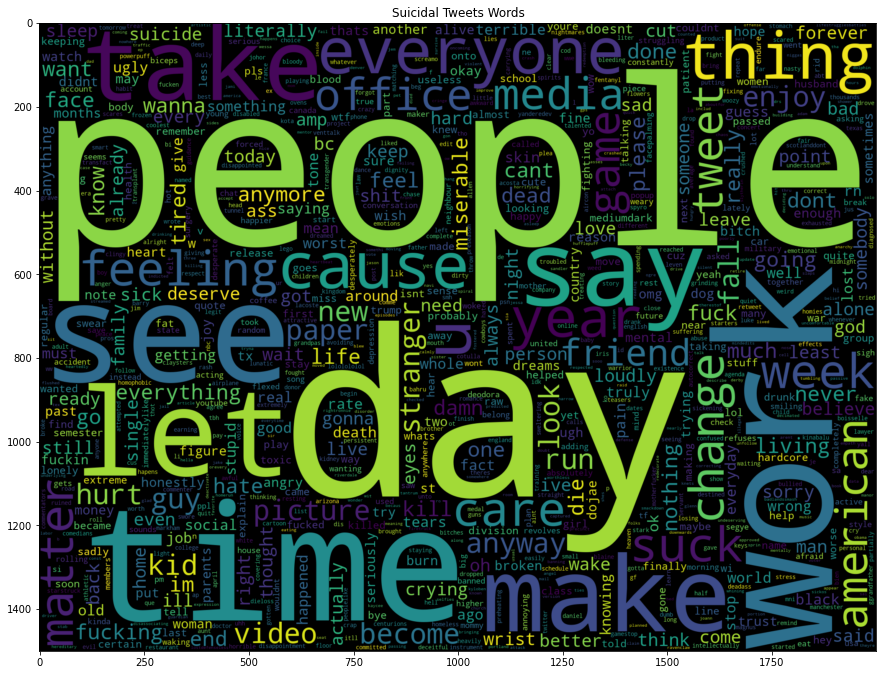

In [ ]:
plt.figure(figsize = (15,20)) 
plt.title("Suicidal Tweets Words")
wc = WordCloud(max_words = 1000, width = 2000 , height = 1500).generate(" ".join((com)))
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
dataset['Suicide'].unique()

array(['Potential Suicide post ', 'Not Suicide post'], dtype=object)

In [ ]:
for i in range(dataset.shape[0]):
  if dataset["Suicide"].iloc[i]=='Not Suicide post':
    dataset["Suicide"].iloc[i]=0
  else:
    dataset["Suicide"].iloc[i]=1
dataset["Suicide"]=np.array(dataset['Suicide']).astype(int)

In [ ]:
#Vectorizing text

In [ ]:
X=dataset['pre']
y=dataset['Suicide']
vectorizer =TfidfVectorizer()
vectorizer.fit(X)

TfidfVectorizer()

In [ ]:
x=vectorizer.transform(X)

In [ ]:
#Train test split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=100)

In [ ]:
labels=["Not Suicide","Suicide"]

In [ ]:
#testing different models

In [ ]:
#machine learning

In [ ]:
#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=40, random_state=0)
RFC.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, random_state=0)

In [ ]:
y_pred = RFC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       164
           1       0.92      0.71      0.80       172

    accuracy                           0.82       336
   macro avg       0.84      0.82      0.82       336
weighted avg       0.84      0.82      0.82       336



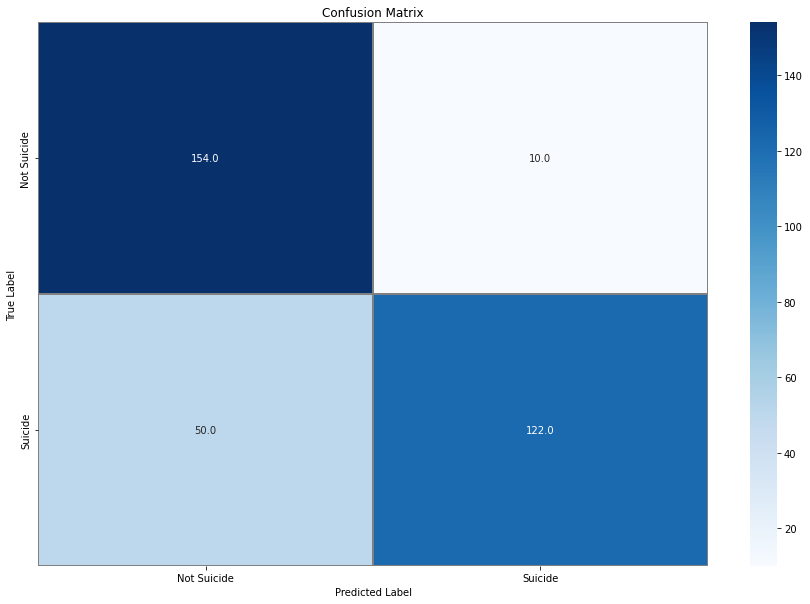

In [ ]:
confusion_mtx = confusion_matrix(y_test,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_pred = KNN.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       164
           1       0.81      0.83      0.82       172

    accuracy                           0.81       336
   macro avg       0.81      0.81      0.81       336
weighted avg       0.81      0.81      0.81       336



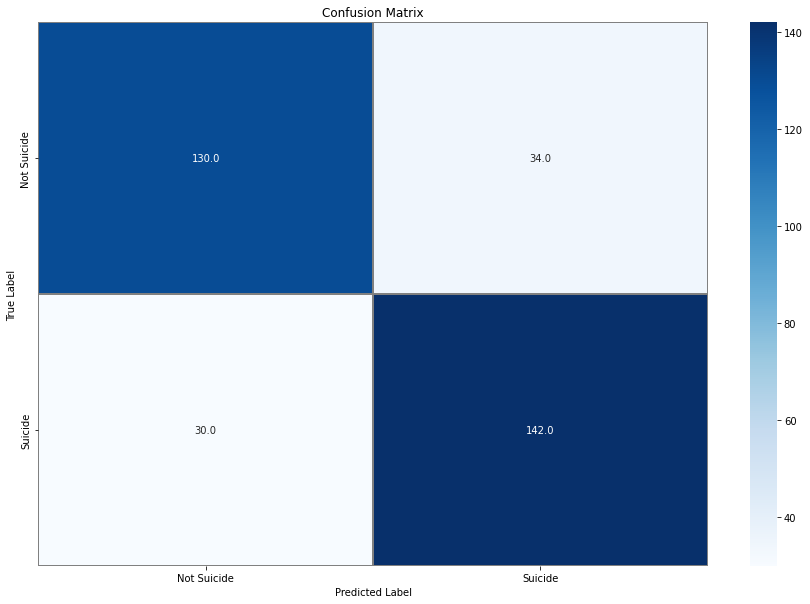

In [ ]:
confusion_mtx = confusion_matrix(y_test,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Decision Tree 

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC = DecisionTreeClassifier(random_state=1)
DTC.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

In [ ]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       164
           1       0.87      0.80      0.84       172

    accuracy                           0.84       336
   macro avg       0.84      0.84      0.84       336
weighted avg       0.84      0.84      0.84       336



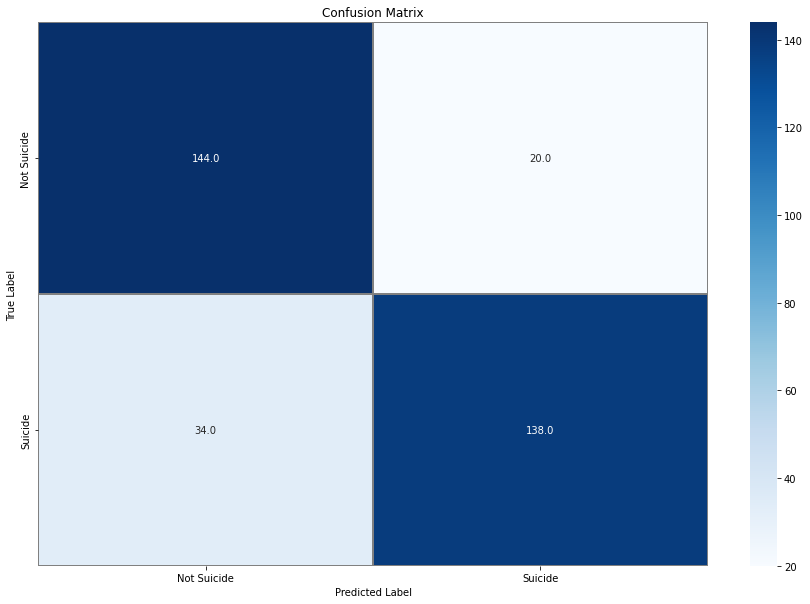

In [ ]:
confusion_mtx = confusion_matrix(y_test,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#deep learning

In [ ]:
#preparing testing and training data

In [ ]:
from sklearn.model_selection import train_test_split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(list(X), np.array(y), test_size=0.30, random_state=100)

In [ ]:
vocab_size = 50000
embedding_dim = 50
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_dl)

word_index = tokenizer.word_index

x_train_sequ = tokenizer.texts_to_sequences(X_train_dl)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_sequ, maxlen=max_length, padding=padding_type, truncating=trunc_type)
training_padded = np.array(training_padded)

x_test_sequ = tokenizer.texts_to_sequences(X_test_dl)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test_sequ, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_padded = np.array(testing_padded)

In [ ]:
#DNN

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 50)           2500000   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_7 (Dense)             (None, 64)                3264      
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,503,394
Trainable params: 2,503,394
Non-trainable params: 0
_________________________________________________________________


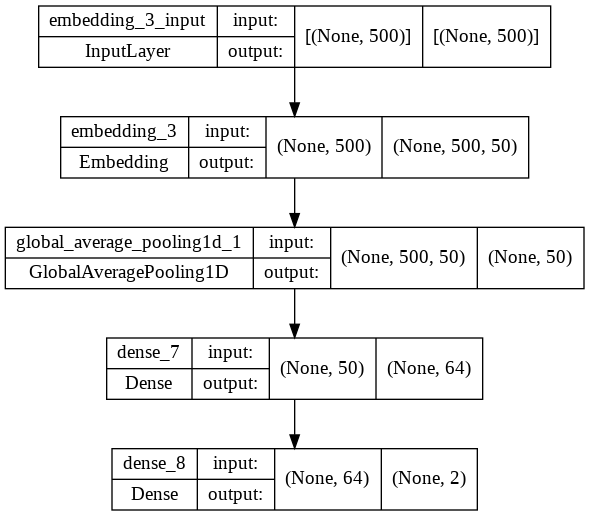

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes= True, show_layer_names=True)

In [ ]:
history = model1.fit(training_padded, y_train_dl, epochs=50, validation_data=(testing_padded, y_test_dl))

Epoch 1/50
25/25 [==============================] - 1s 38ms/step - loss: 0.6942 - accuracy: 0.4847 - val_loss: 0.6932 - val_accuracy: 0.4881
Epoch 2/50
25/25 [==============================] - 1s 35ms/step - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6935 - val_accuracy: 0.4881
Epoch 3/50
25/25 [==============================] - 1s 34ms/step - loss: 0.6928 - accuracy: 0.5051 - val_loss: 0.6935 - val_accuracy: 0.4881
Epoch 4/50
25/25 [==============================] - 1s 34ms/step - loss: 0.6925 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.4881
Epoch 5/50
25/25 [==============================] - 1s 31ms/step - loss: 0.6927 - accuracy: 0.5013 - val_loss: 0.6922 - val_accuracy: 0.7143
Epoch 6/50
25/25 [==============================] - 1s 33ms/step - loss: 0.6917 - accuracy: 0.5486 - val_loss: 0.6923 - val_accuracy: 0.4881
Epoch 7/50
25/25 [==============================] - 1s 32ms/step - loss: 0.6914 - accuracy: 0.5064 - val_loss: 0.6920 - val_accuracy: 0.4881
Epoch 8/50
25

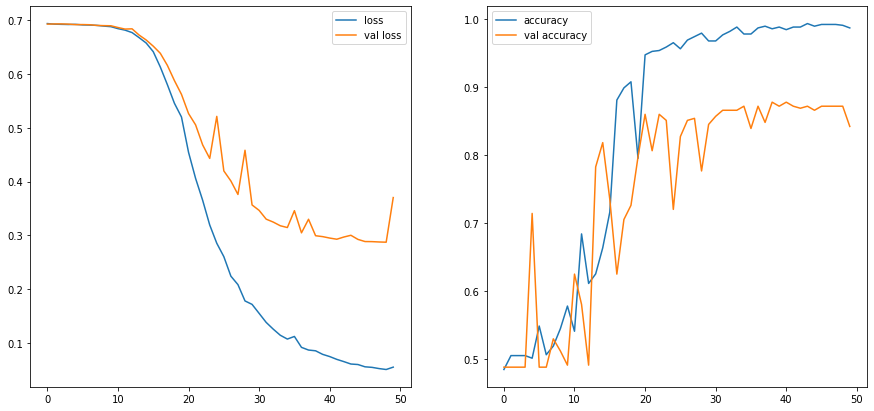

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].plot(history.history['loss'],label="loss")
axes[0].plot(history.history['val_loss'],label="val loss")
axes[0].legend()
axes[1].plot(history.history['accuracy'],label="accuracy")
axes[1].plot(history.history['val_accuracy'],label="val accuracy")
axes[1].legend()

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       164
           1       0.95      0.73      0.83       172

    accuracy                           0.84       336
   macro avg       0.86      0.85      0.84       336
weighted avg       0.86      0.84      0.84       336



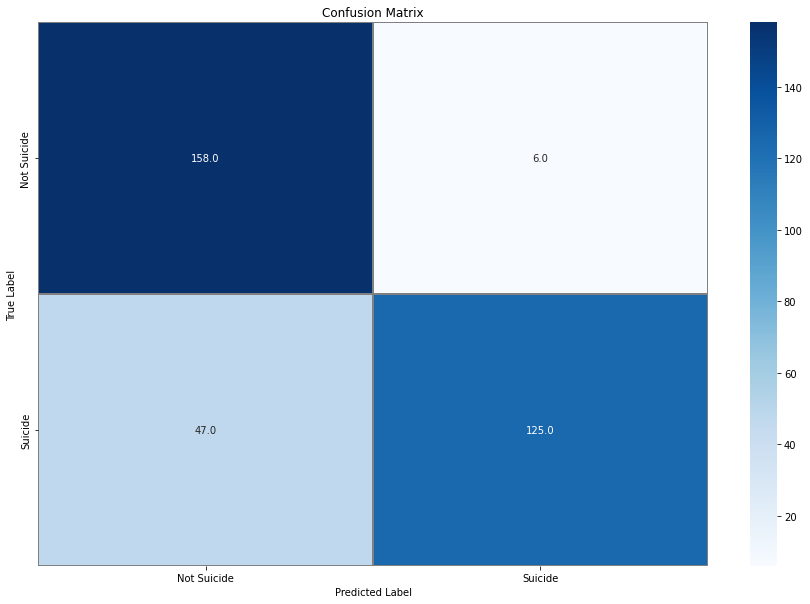

In [ ]:
y_pred = model1.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_test_dl),y_pred))
confusion_mtx = confusion_matrix(np.array(y_test_dl),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#Conv_Lstm 

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(6,12, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(13, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 50)           2500000   
                                                                 
 conv1d_1 (Conv1D)           (None, 489, 6)            3606      
                                                                 
 bidirectional_2 (Bidirectio  (None, 26)               2080      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 64)                1728      
                                                                 
 dense_10 (Dense)            (None, 2)                 130       
                                                                 
Total params: 2,507,544
Trainable params: 2,507,544
Non-trainable params: 0
____________________________________________

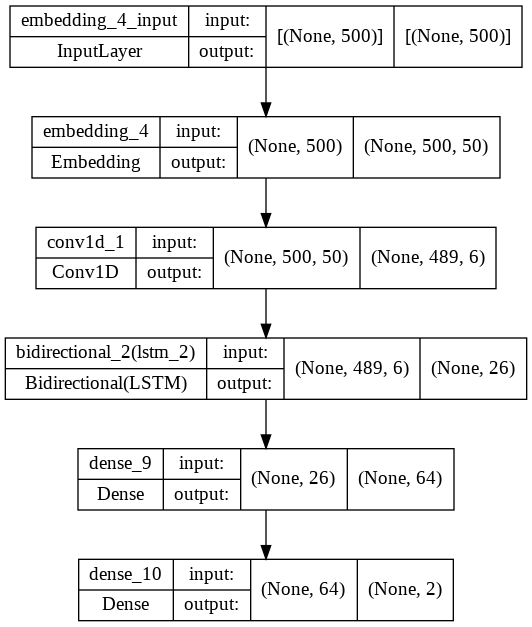

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model2, to_file='model2_plot.png', show_shapes= True, show_layer_names=True)

In [ ]:
history = model2.fit(training_padded, y_train_dl, epochs=15, validation_data=(testing_padded, y_test_dl), verbose=2)

Epoch 1/15
25/25 - 29s - loss: 0.6930 - accuracy: 0.5102 - val_loss: 0.6889 - val_accuracy: 0.5179 - 29s/epoch - 1s/step
Epoch 2/15
25/25 - 19s - loss: 0.6587 - accuracy: 0.7123 - val_loss: 0.6203 - val_accuracy: 0.7143 - 19s/epoch - 751ms/step
Epoch 3/15
25/25 - 19s - loss: 0.4489 - accuracy: 0.8427 - val_loss: 0.3920 - val_accuracy: 0.8363 - 19s/epoch - 751ms/step
Epoch 4/15
25/25 - 19s - loss: 0.1440 - accuracy: 0.9527 - val_loss: 0.4156 - val_accuracy: 0.7857 - 19s/epoch - 750ms/step
Epoch 5/15
25/25 - 19s - loss: 0.0742 - accuracy: 0.9744 - val_loss: 0.3142 - val_accuracy: 0.8690 - 19s/epoch - 756ms/step
Epoch 6/15
25/25 - 19s - loss: 0.0323 - accuracy: 0.9910 - val_loss: 0.3683 - val_accuracy: 0.8780 - 19s/epoch - 748ms/step
Epoch 7/15
25/25 - 19s - loss: 0.0214 - accuracy: 0.9936 - val_loss: 0.3629 - val_accuracy: 0.8780 - 19s/epoch - 743ms/step
Epoch 8/15
25/25 - 19s - loss: 0.0194 - accuracy: 0.9949 - val_loss: 0.3903 - val_accuracy: 0.8839 - 19s/epoch - 745ms/step
Epoch 9/15


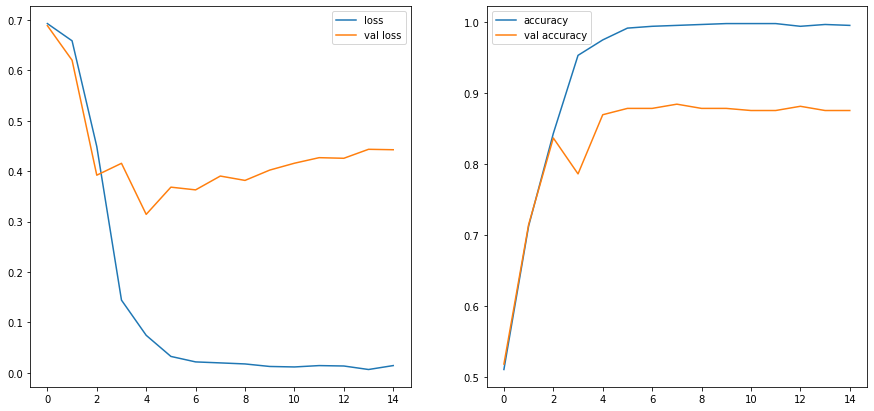

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].plot(history.history['loss'],label="loss")
axes[0].plot(history.history['val_loss'],label="val loss")
axes[0].legend()
axes[1].plot(history.history['accuracy'],label="accuracy")
axes[1].plot(history.history['val_accuracy'],label="val accuracy")
axes[1].legend()

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       164
           1       0.89      0.86      0.88       172

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.87       336
weighted avg       0.88      0.88      0.88       336



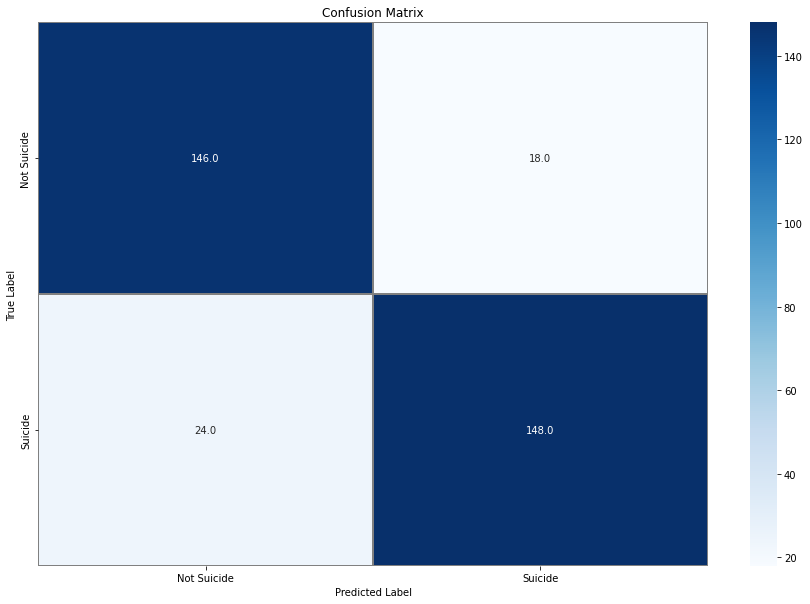

In [ ]:
y_pred = model2.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_test_dl),y_pred))
confusion_mtx = confusion_matrix(np.array(y_test_dl),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#RNN

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, dropout=0.2, recurrent_dropout=0.2)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 500, 50)           2500000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 12)               2736      
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 16)                208       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                544       
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                      

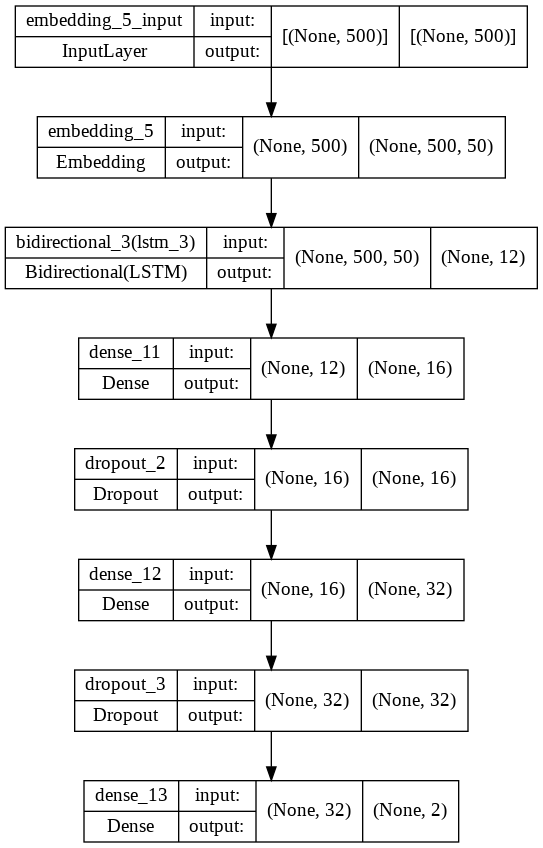

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model3, to_file='model_plot3.png', show_shapes= True, show_layer_names=True)

In [ ]:
history = model3.fit(training_padded, y_train_dl, epochs=5, validation_data=(testing_padded, y_test_dl))

Epoch 1/5
25/25 [==============================] - 26s 813ms/step - loss: 0.6919 - accuracy: 0.5192 - val_loss: 0.6888 - val_accuracy: 0.6369
Epoch 2/5
25/25 [==============================] - 20s 783ms/step - loss: 0.6763 - accuracy: 0.6240 - val_loss: 0.6610 - val_accuracy: 0.8244
Epoch 3/5
25/25 [==============================] - 19s 779ms/step - loss: 0.6230 - accuracy: 0.7455 - val_loss: 0.5770 - val_accuracy: 0.8482
Epoch 4/5
25/25 [==============================] - 20s 781ms/step - loss: 0.4718 - accuracy: 0.8696 - val_loss: 0.4131 - val_accuracy: 0.8542
Epoch 5/5
25/25 [==============================] - 20s 781ms/step - loss: 0.2958 - accuracy: 0.9207 - val_loss: 0.3226 - val_accuracy: 0.8631


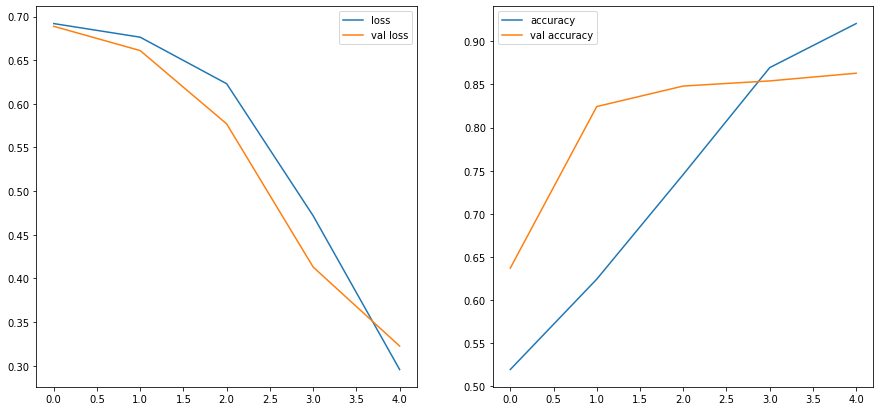

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
axes[0].plot(history.history['loss'],label="loss")
axes[0].plot(history.history['val_loss'],label="val loss")
axes[0].legend()
axes[1].plot(history.history['accuracy'],label="accuracy")
axes[1].plot(history.history['val_accuracy'],label="val accuracy")
axes[1].legend()

              precision    recall  f1-score   support

           0       0.81      0.93      0.87       164
           1       0.93      0.80      0.86       172

    accuracy                           0.86       336
   macro avg       0.87      0.86      0.86       336
weighted avg       0.87      0.86      0.86       336



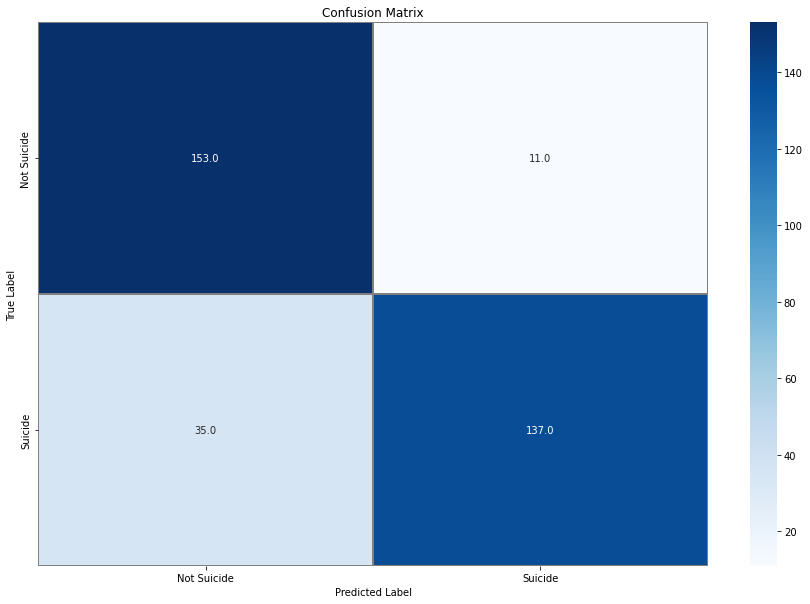

In [ ]:
y_pred = model3.predict(testing_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_test_dl),y_pred))
confusion_mtx = confusion_matrix(np.array(y_test_dl),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#test model with data from other dataset

In [ ]:
test=pd.read_csv("twitter-suicidal_data.csv")
test=test.dropna()
processed_test=[]
for i in test['tweet']:
  processed_test.append(pre(i))
test["pre"]=processed_test

X_val_dl=test['pre']
y_val=test['intention']
X_val=vectorizer.transform(X_val_dl)

In [ ]:
#ml models

In [ ]:
#random forest

              precision    recall  f1-score   support

           0       0.82      0.68      0.74      5121
           1       0.66      0.80      0.73      3998

    accuracy                           0.73      9119
   macro avg       0.74      0.74      0.73      9119
weighted avg       0.75      0.73      0.73      9119



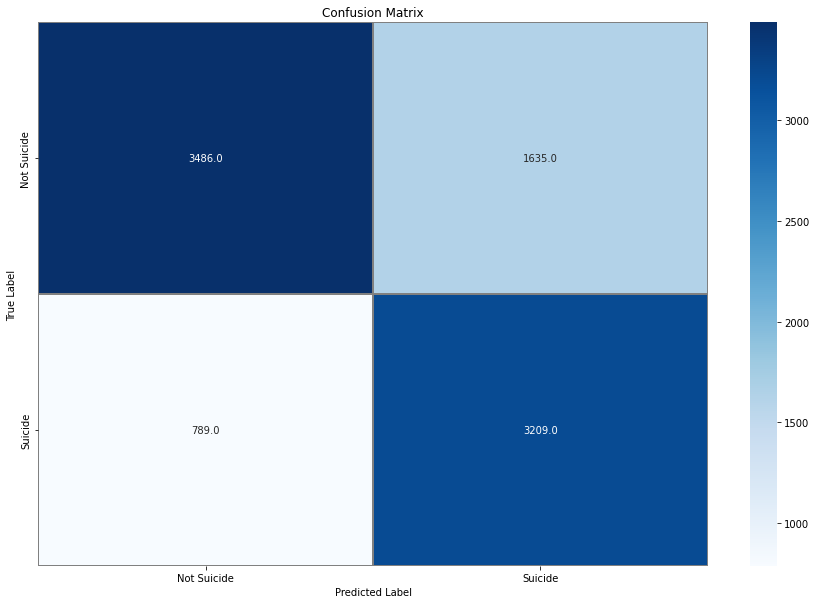

In [ ]:
y_pred = RFC.predict(X_val)
print(classification_report(y_val,y_pred))
confusion_mtx = confusion_matrix(y_val,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#knn

              precision    recall  f1-score   support

           0       0.74      0.55      0.63      5121
           1       0.57      0.76      0.65      3998

    accuracy                           0.64      9119
   macro avg       0.66      0.65      0.64      9119
weighted avg       0.67      0.64      0.64      9119



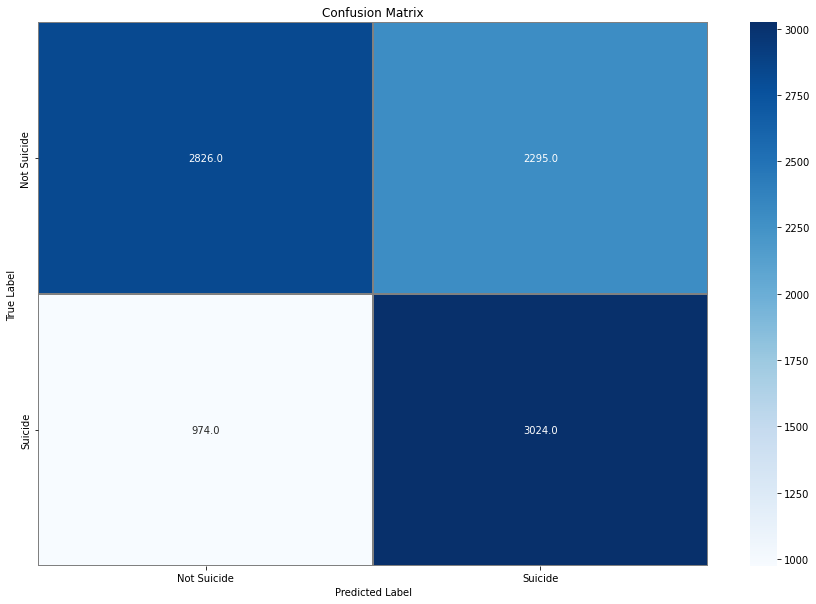

In [ ]:
y_pred = KNN.predict(X_val)
print(classification_report(y_val,y_pred))
confusion_mtx = confusion_matrix(y_val,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#decision tree

              precision    recall  f1-score   support

           0       0.80      0.59      0.68      5121
           1       0.61      0.81      0.69      3998

    accuracy                           0.69      9119
   macro avg       0.70      0.70      0.69      9119
weighted avg       0.71      0.69      0.69      9119



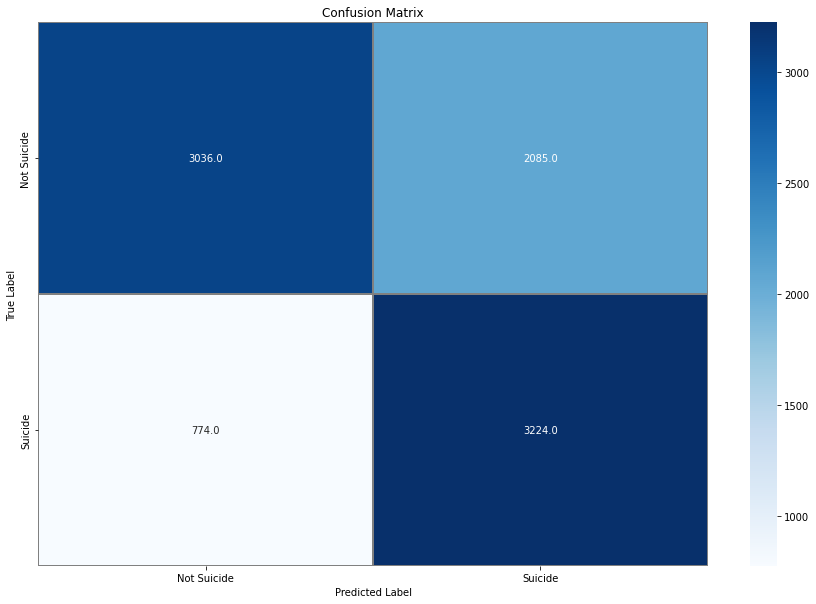

In [ ]:
y_pred = DTC.predict(X_val)
print(classification_report(y_val,y_pred))
confusion_mtx = confusion_matrix(y_val,y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#dl models

In [ ]:
#dnn

              precision    recall  f1-score   support

           0       0.86      0.74      0.79      5121
           1       0.72      0.85      0.78      3998

    accuracy                           0.79      9119
   macro avg       0.79      0.79      0.79      9119
weighted avg       0.80      0.79      0.79      9119



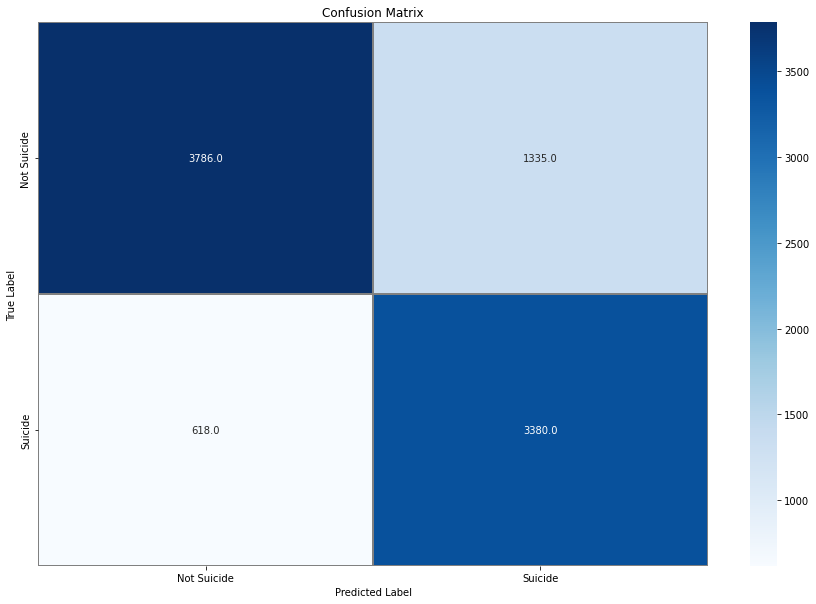

In [ ]:
val_data = tokenizer.texts_to_sequences(list(X_val_dl))
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model1.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_val),y_pred))
confusion_mtx = confusion_matrix(np.array(y_val),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#convLstm

              precision    recall  f1-score   support

           0       0.76      0.60      0.67      5121
           1       0.60      0.76      0.67      3998

    accuracy                           0.67      9119
   macro avg       0.68      0.68      0.67      9119
weighted avg       0.69      0.67      0.67      9119



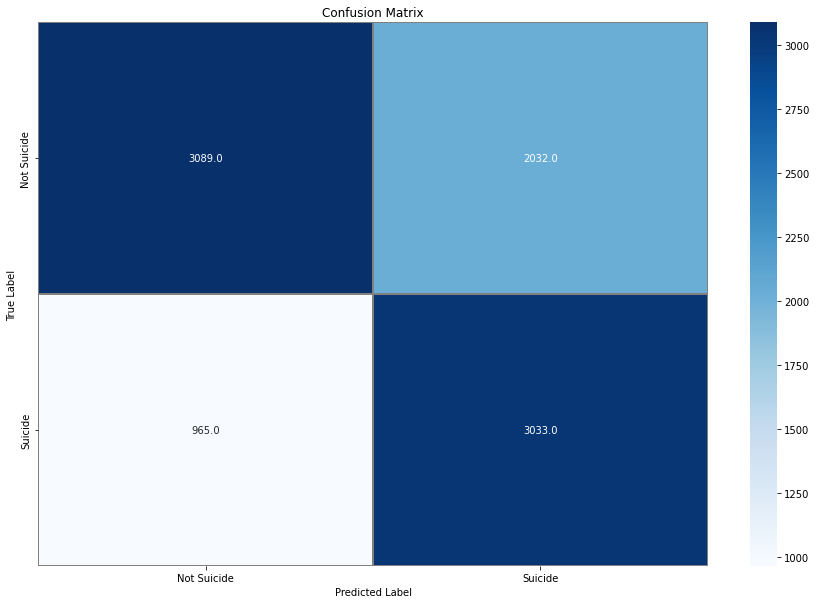

In [ ]:
val_data = tokenizer.texts_to_sequences(list(X_val_dl))
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model2.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_val),y_pred))
confusion_mtx = confusion_matrix(np.array(y_val),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#RNN

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      5121
           1       0.69      0.89      0.78      3998

    accuracy                           0.78      9119
   macro avg       0.79      0.79      0.78      9119
weighted avg       0.80      0.78      0.78      9119



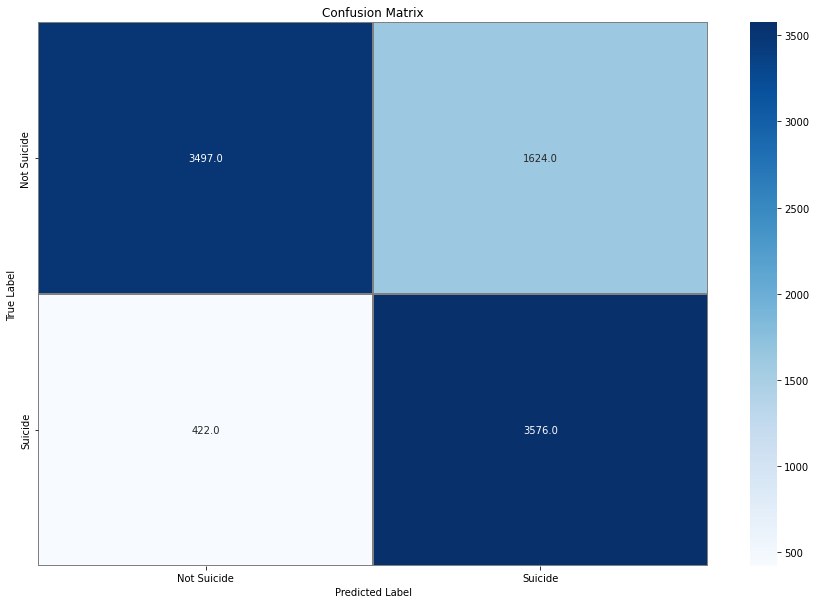

In [ ]:
val_data = tokenizer.texts_to_sequences(list(X_val_dl))
val_data = tf.keras.preprocessing.sequence.pad_sequences(val_data, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model3.predict(val_data)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(np.array(y_val),y_pred))
confusion_mtx = confusion_matrix(np.array(y_val),y_pred)
f,ax = plt.subplots(figsize=(15, 10))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.title("Confusion Matrix")
plt.show()

In [ ]:
#test sentences

In [ ]:
labels

['Not Suicide', 'Suicide']

In [ ]:
#"RFC"

In [ ]:
a=(pre("I want a vacaction"))
val_data=vectorizer.transform([(' '.join(eval(a)))])
y_pred = RFC.predict(val_data)
print("text is similar to text witht he label = "+labels[y_pred[0]])

text is similar to text witht he label = Not Suicide


In [ ]:
a=(pre("Took all my pills, be dead soon, bye-bye everyone"))
val_data=vectorizer.transform([(' '.join(eval(a)))])
y_pred = RFC.predict(val_data)
print("text is similar to text witht he label = "+labels[y_pred[0]])

text is similar to text witht he label = Not Suicide


In [ ]:
#"DNN"

In [ ]:
val=pd.DataFrame()
val["text"]=["I lovw Arsenal"]
val["pre"]=pre(val["text"][0])
test = tokenizer.texts_to_sequences(list(val["pre"]))
test = tf.keras.preprocessing.sequence.pad_sequences(test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model1.predict(test)
y_pred = np.argmax(y_pred, axis=1)
print("text is similar to text witht he label = "+labels[y_pred[0]])

text is similar to text witht he label = Not Suicide


In [ ]:
val=pd.DataFrame()
val["text"]=["Took all my pills, be dead soon, bye bye everyone."]
val["pre"]=pre(val["text"][0])
test = tokenizer.texts_to_sequences(list(val["pre"]))
test = tf.keras.preprocessing.sequence.pad_sequences(test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
y_pred = model1.predict(test)
y_pred = np.argmax(y_pred, axis=1)
print("text is similar to text witht he label = "+labels[y_pred[0]])

text is similar to text witht he label = Suicide
